# ОИАД. Лабораторная работа №3

## 1. Подготовка данных
1. Проверить наличие пропусков и выбросов
2. Привести категориальные признаки к числовым
3. Вычислить парные корреляции признаков

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

Пропуски в данных:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Проверка выбросов (по правилу 3σ):
age: 0 выбросов
bmi: 4 выбросов
charges: 7 выбросов


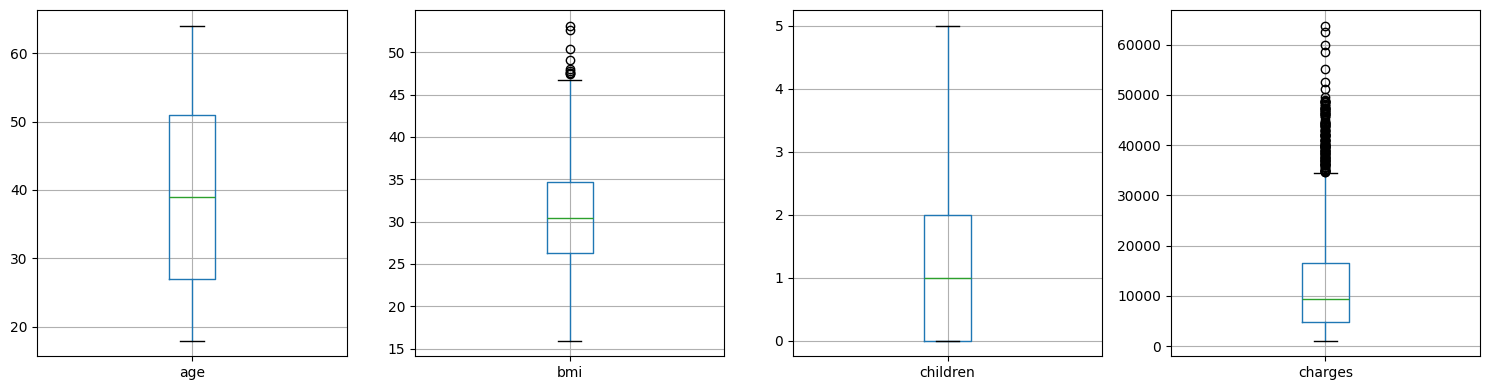


Первые 5 строк после кодирования:
   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       0  16884.92400
1   18    1  33.770         1       0       1   1725.55230
2   28    1  33.000         3       0       1   4449.46200
3   33    1  22.705         0       0       2  21984.47061
4   32    1  28.880         0       0       2   3866.85520


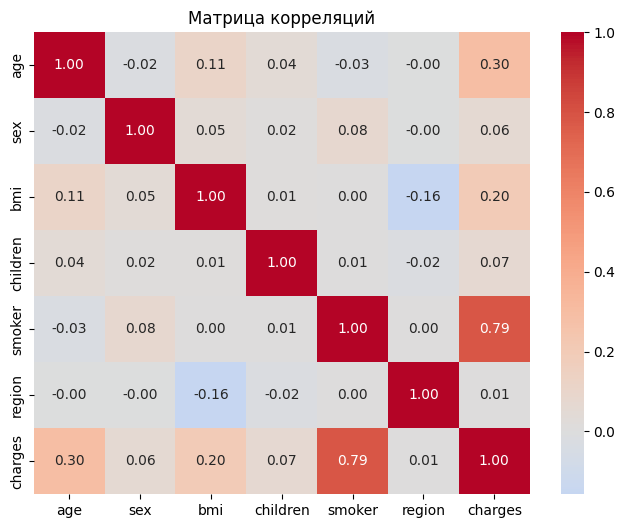

In [17]:
df = pd.read_csv('insurance.csv')

# Проверка пропусков
print("Пропуски в данных:")
print(df.isnull().sum())

# Проверка выбросов
print("\nПроверка выбросов (по правилу 3σ):")
for col in ['age', 'bmi', 'charges']:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[(df[col] > mean + 3*std) | (df[col] < mean - 3*std)]
    print(f"{col}: {len(outliers)} выбросов")

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
df.boxplot(column='age', ax=axes[0])
df.boxplot(column='bmi', ax=axes[1])
df.boxplot(column='children', ax=axes[2])
df.boxplot(column='charges', ax=axes[3])
plt.tight_layout()
plt.show()

# Категориальные признаки к числовым
df_encoded = df.copy()
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})
df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})
df_encoded['region'] = df_encoded['region'].map({
    'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3
})

print("\nПервые 5 строк после кодирования:")
print(df_encoded.head())

# Парные корреляции
plt.figure(figsize=(8, 6))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций')
plt.show()


## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

In [18]:
# Подготовка данных
X = df_encoded[['age', 'sex', 'bmi', 'children', 'smoker', 'region']].values
y = df_encoded['charges'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Размеры данных: X_train {X_train.shape}, X_test {X_test.shape}")

# Аналитическое решение
class LinearRegressionAnalytical:
    def __init__(self):
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        X_with_bias = np.c_[np.ones(X.shape[0]), X]
        try:
            self.theta = np.linalg.inv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
        except np.linalg.LinAlgError:
            self.theta = np.linalg.pinv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
        self.bias = self.theta[0]
        self.weights = self.theta[1:]
        print("Аналитическая модель обучена")
    
    def predict(self, X):
        return X @ self.weights + self.bias
    
    def mse(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

# Градиентный спуск
class LinearRegressionGradient:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iter):
            y_pred = X @ self.weights + self.bias
            error = y_pred - y
            dw = (1/n_samples) * X.T @ error
            db = (1/n_samples) * np.sum(error)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            mse = np.mean(error ** 2)
            self.loss_history.append(mse)
        
        print(f"Градиентный спуск завершен за {self.n_iter} итераций, финальный MSE: {mse:,.2f}")
    
    def predict(self, X):
        return X @ self.weights + self.bias
    
    def mse(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

# Обучение моделей
print("\nОбучение линейных моделей...")
lr_analytical = LinearRegressionAnalytical()
lr_analytical.fit(X_train, y_train)

lr_gradient = LinearRegressionGradient(learning_rate=0.01, n_iter=1000)
lr_gradient.fit(X_train, y_train)

print(f"\nСравнение линейных моделей на обучающих данных:")
print(f"Аналитическая MSE: {lr_analytical.mse(X_train, y_train):,.2f}")
print(f"Градиентный спуск MSE: {lr_gradient.mse(X_train, y_train):,.2f}")

Размеры данных: X_train (1070, 6), X_test (268, 6)

Обучение линейных моделей...
Аналитическая модель обучена
Градиентный спуск завершен за 1000 итераций, финальный MSE: 37,280,664.28

Сравнение линейных моделей на обучающих данных:
Аналитическая MSE: 37,280,663.22
Градиентный спуск MSE: 37,280,664.26


## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

In [19]:
# Аналитическое решение с регуляризацией
class RidgeRegressionAnalytical:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        X_with_bias = np.c_[np.ones(X.shape[0]), X]
        n_features = X_with_bias.shape[1]
        identity_matrix = np.eye(n_features)
        identity_matrix[0, 0] = 0
        
        self.theta = np.linalg.inv(X_with_bias.T @ X_with_bias + 
                                 self.alpha * identity_matrix) @ X_with_bias.T @ y
        self.bias = self.theta[0]
        self.weights = self.theta[1:]
        print(f"Ridge аналитическая модель обучена (alpha={self.alpha})")
    
    def predict(self, X):
        return X @ self.weights + self.bias
    
    def mse(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

# Градиентный спуск с регуляризацией
class RidgeRegressionGradient:
    def __init__(self, alpha=1.0, learning_rate=0.01, n_iter=1000):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iter):
            y_pred = X @ self.weights + self.bias
            error = y_pred - y
            dw = (1/n_samples) * X.T @ error + (self.alpha/n_samples) * self.weights
            db = (1/n_samples) * np.sum(error)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            mse = np.mean(error ** 2) + self.alpha * np.sum(self.weights ** 2)
            self.loss_history.append(mse)
        
        print(f"Ridge градиентный спуск завершен (alpha={self.alpha}), финальный MSE: {mse:,.2f}")
    
    def predict(self, X):
        return X @ self.weights + self.bias
    
    def mse(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

# Подбор оптимального alpha
print("\nПодбор оптимального параметра регуляризации...")
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
best_alpha = alphas[0]
best_mse = float('inf')

for alpha in alphas:
    model = RidgeRegressionAnalytical(alpha=alpha)
    model.fit(X_train, y_train)
    mse = model.mse(X_test, y_test)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha

print(f"Оптимальный alpha: {best_alpha}")

# Обучение моделей с регуляризацией
ridge_analytical = RidgeRegressionAnalytical(alpha=best_alpha)
ridge_analytical.fit(X_train, y_train)

ridge_gradient = RidgeRegressionGradient(alpha=best_alpha, learning_rate=0.01, n_iter=1000)
ridge_gradient.fit(X_train, y_train)

print(f"\nСравнение Ridge моделей на обучающих данных:")
print(f"Ridge аналитическая MSE: {ridge_analytical.mse(X_train, y_train):,.2f}")
print(f"Ridge градиентный спуск MSE: {ridge_gradient.mse(X_train, y_train):,.2f}")


Подбор оптимального параметра регуляризации...
Ridge аналитическая модель обучена (alpha=0.001)
Ridge аналитическая модель обучена (alpha=0.01)
Ridge аналитическая модель обучена (alpha=0.1)
Ridge аналитическая модель обучена (alpha=1)
Ridge аналитическая модель обучена (alpha=10)
Ridge аналитическая модель обучена (alpha=100)
Оптимальный alpha: 0.001
Ridge аналитическая модель обучена (alpha=0.001)
Ridge градиентный спуск завершен (alpha=0.001), финальный MSE: 37,389,292.67

Сравнение Ridge моделей на обучающих данных:
Ridge аналитическая MSE: 37,280,663.22
Ridge градиентный спуск MSE: 37,280,664.28


## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [23]:
# Константная модель
class ConstantModel:
    def __init__(self):
        self.constant = None
    
    def fit(self, X, y):
        self.constant = np.mean(y)
        print("Константная модель обучена")
    
    def predict(self, X):
        return np.full(X.shape[0], self.constant)
    
    def mse(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

# Обучение константной модели
constant_model = ConstantModel()
constant_model.fit(X_train, y_train)

# Определение лучших моделей из пунктов 2 и 3
mse_lr_analytical_test = lr_analytical.mse(X_test, y_test)
mse_lr_gradient_test = lr_gradient.mse(X_test, y_test)
mse_ridge_analytical_test = ridge_analytical.mse(X_test, y_test)
mse_ridge_gradient_test = ridge_gradient.mse(X_test, y_test)

best_lr_mse = min(mse_lr_analytical_test, mse_lr_gradient_test)
best_ridge_mse = min(mse_ridge_analytical_test, mse_ridge_gradient_test)

# Сравнение моделей на тестовых данных
print("\nСравнение моделей по MSE на тестовых данных:")
print(f"Константная модель: {constant_model.mse(X_test, y_test):,.2f}")
print(f"Лучшая линейная регрессия: {best_lr_mse:,.2f}")
print(f"Лучшая Ridge регрессия: {best_ridge_mse:,.2f}")

# Анализ улучшения
baseline_mse = constant_model.mse(X_test, y_test)
lr_improvement = ((baseline_mse - best_lr_mse) / baseline_mse) * 100
ridge_improvement = ((baseline_mse - best_ridge_mse) / baseline_mse) * 100

print(f"\nУлучшение по сравнению с константной моделью:")
print(f"Линейная регрессия: {lr_improvement:.1f}%")
print(f"Ridge регрессия: {ridge_improvement:.1f}%")

Константная модель обучена

Сравнение моделей по MSE на тестовых данных:
Константная модель: 155,391,443.68
Лучшая линейная регрессия: 33,635,210.43
Лучшая Ridge регрессия: 33,635,216.90

Улучшение по сравнению с константной моделью:
Линейная регрессия: 78.4%
Ridge регрессия: 78.4%
